# Assignment 3: Cavity Blockade

In [50]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import qutip as qtp

from plots import *
from solving_methods import *

from scipy.special import factorial
from joblib import Parallel, delayed
from itertools import product

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Hamiltonian:

$H = \hbar \omega_c \mathbb{I}_a \otimes\hat{a}^\dag\hat{a} + \hbar \omega_a \ket{e}\bra{e} \otimes \mathbb{I}_c + \hbar \tilde{g}\left( \sigma^+ \hat{a} + \sigma^- \hat{a}^\dag\right) + (\mathcal{E}e^{i\omega t} \mathbb{I}\otimes\hat{a} +\text{h.c.}) \\$

After RWA ($\hbar = 1$):

$H = \delta_C a^\dag a + \delta_a \ket{e}\bra{e} + \tilde{g}(\sigma^+ a + \sigma_- a^\dag) + \mathcal{E}(a + a^\dag)$

### Decoupled dynamics: $\omega = \omega_a = \omega_c$ and $\tilde{g}=0$

Initial state $\ket{g, 0}$, small atom decay rate $\Gamma$ and small cavity dissipation rate $\kappa$

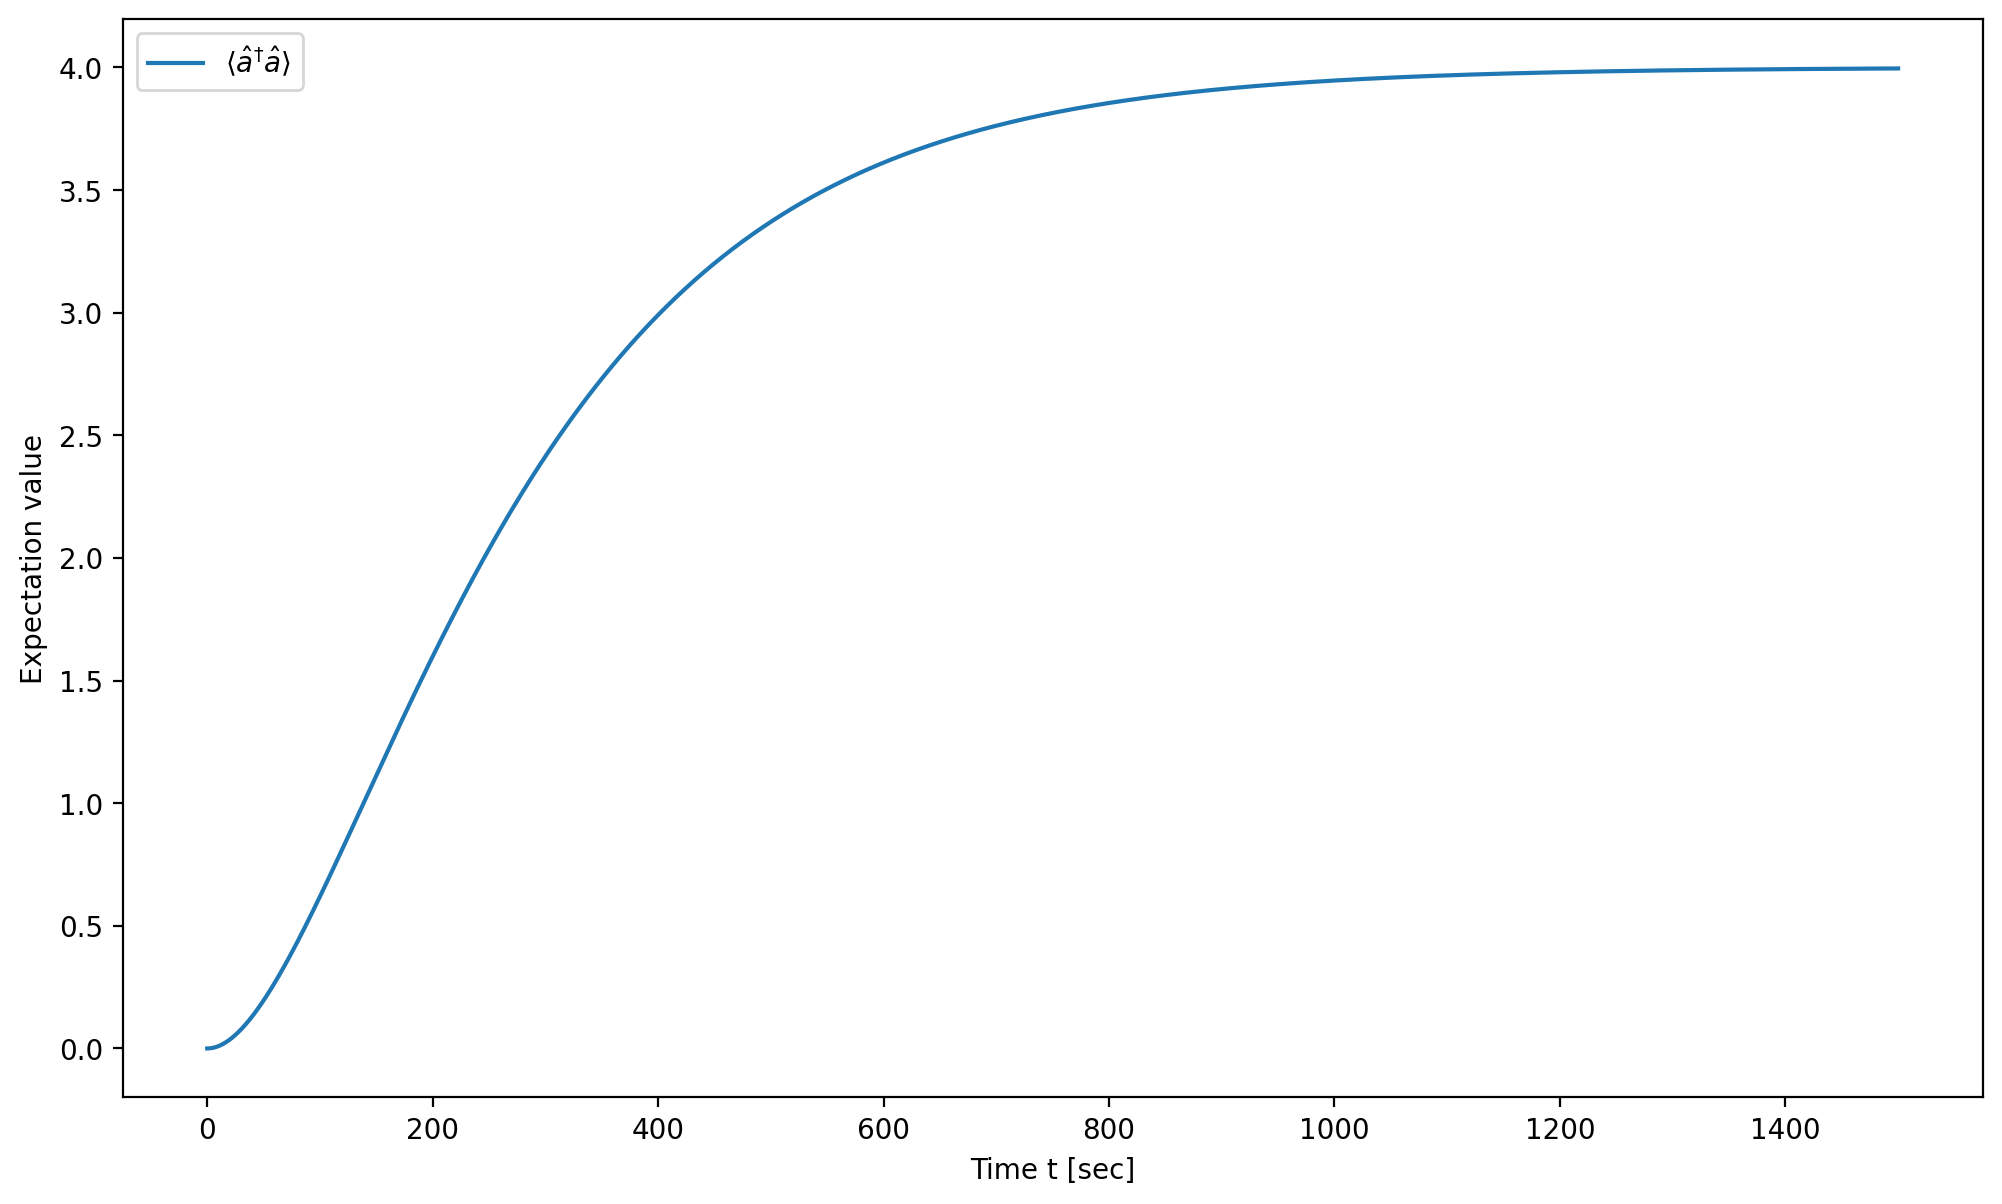

In [3]:
T0    = 0
Tf    = 1500
Nt    = Tf*50

OMEGA = 1  # Resonant frequency
N_ph  = 20  # Fock space dimension
E     = 0.01  # Pumping field amplitude
GAMMA = 0.01 # Atom decay rate
KAPPA = 0.01 # Cavity dissipation rate

psi0    = qtp.tensor(qtp.basis(2,1), qtp.fock(N_ph, 0)) # Initial state
result = solve_JC_LME(psi0, 0, 0, 0, E, KAPPA, GAMMA, N_ph, T0, Tf, Nt, True)

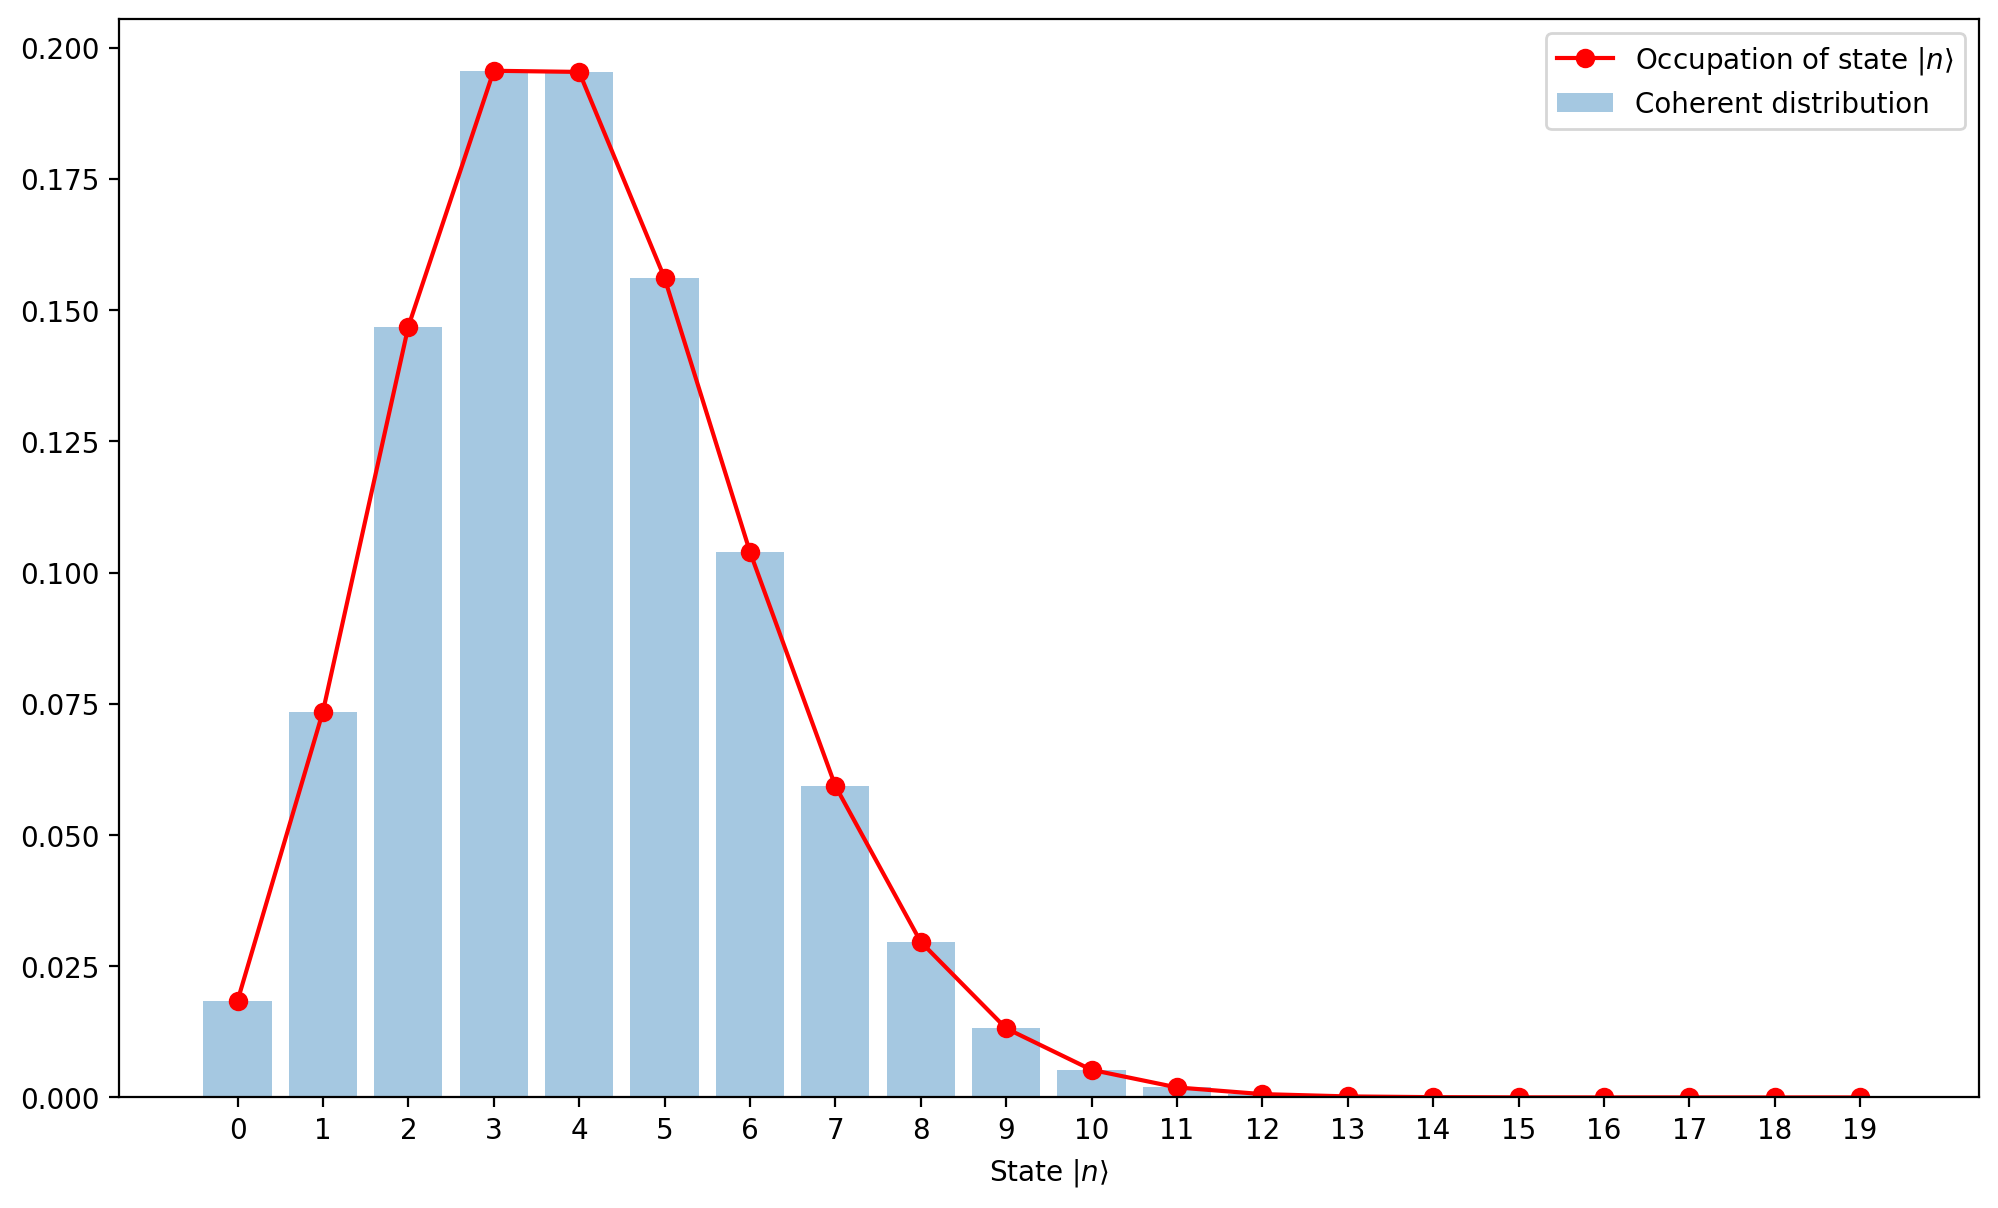

In [4]:
# Steady-state occupations
rho_ss = result.final_state
rho_cav_g0 = rho_ss.ptrace(1)     # dim (N_ph, N_ph)
occupations = rho_cav_g0.diag()

# Coherent state distribution (Poisson)
N_list   = np.arange(N_ph)
mean_N   = result.expect[0][-1]
coherent = np.exp(-mean_N) * mean_N**N_list / factorial(N_list)

plt.figure(dpi=200, figsize=(12, 7))
plt.plot(N_list, occupations, "r-o", label=r"Occupation of state $\vert{n}\rangle$")
plt.xticks(N_list)
plt.bar(N_list, coherent, label=r"Coherent distribution", alpha=0.4)

plt.xlabel(r"State $\vert n \rangle$")
plt.legend()
plt.show()

### Coupled dynamics: $\tilde{g} \neq 0$, $\omega = \omega_c - \tilde{g}, \, \tilde{g} >> \Gamma >> \mathcal{E}$

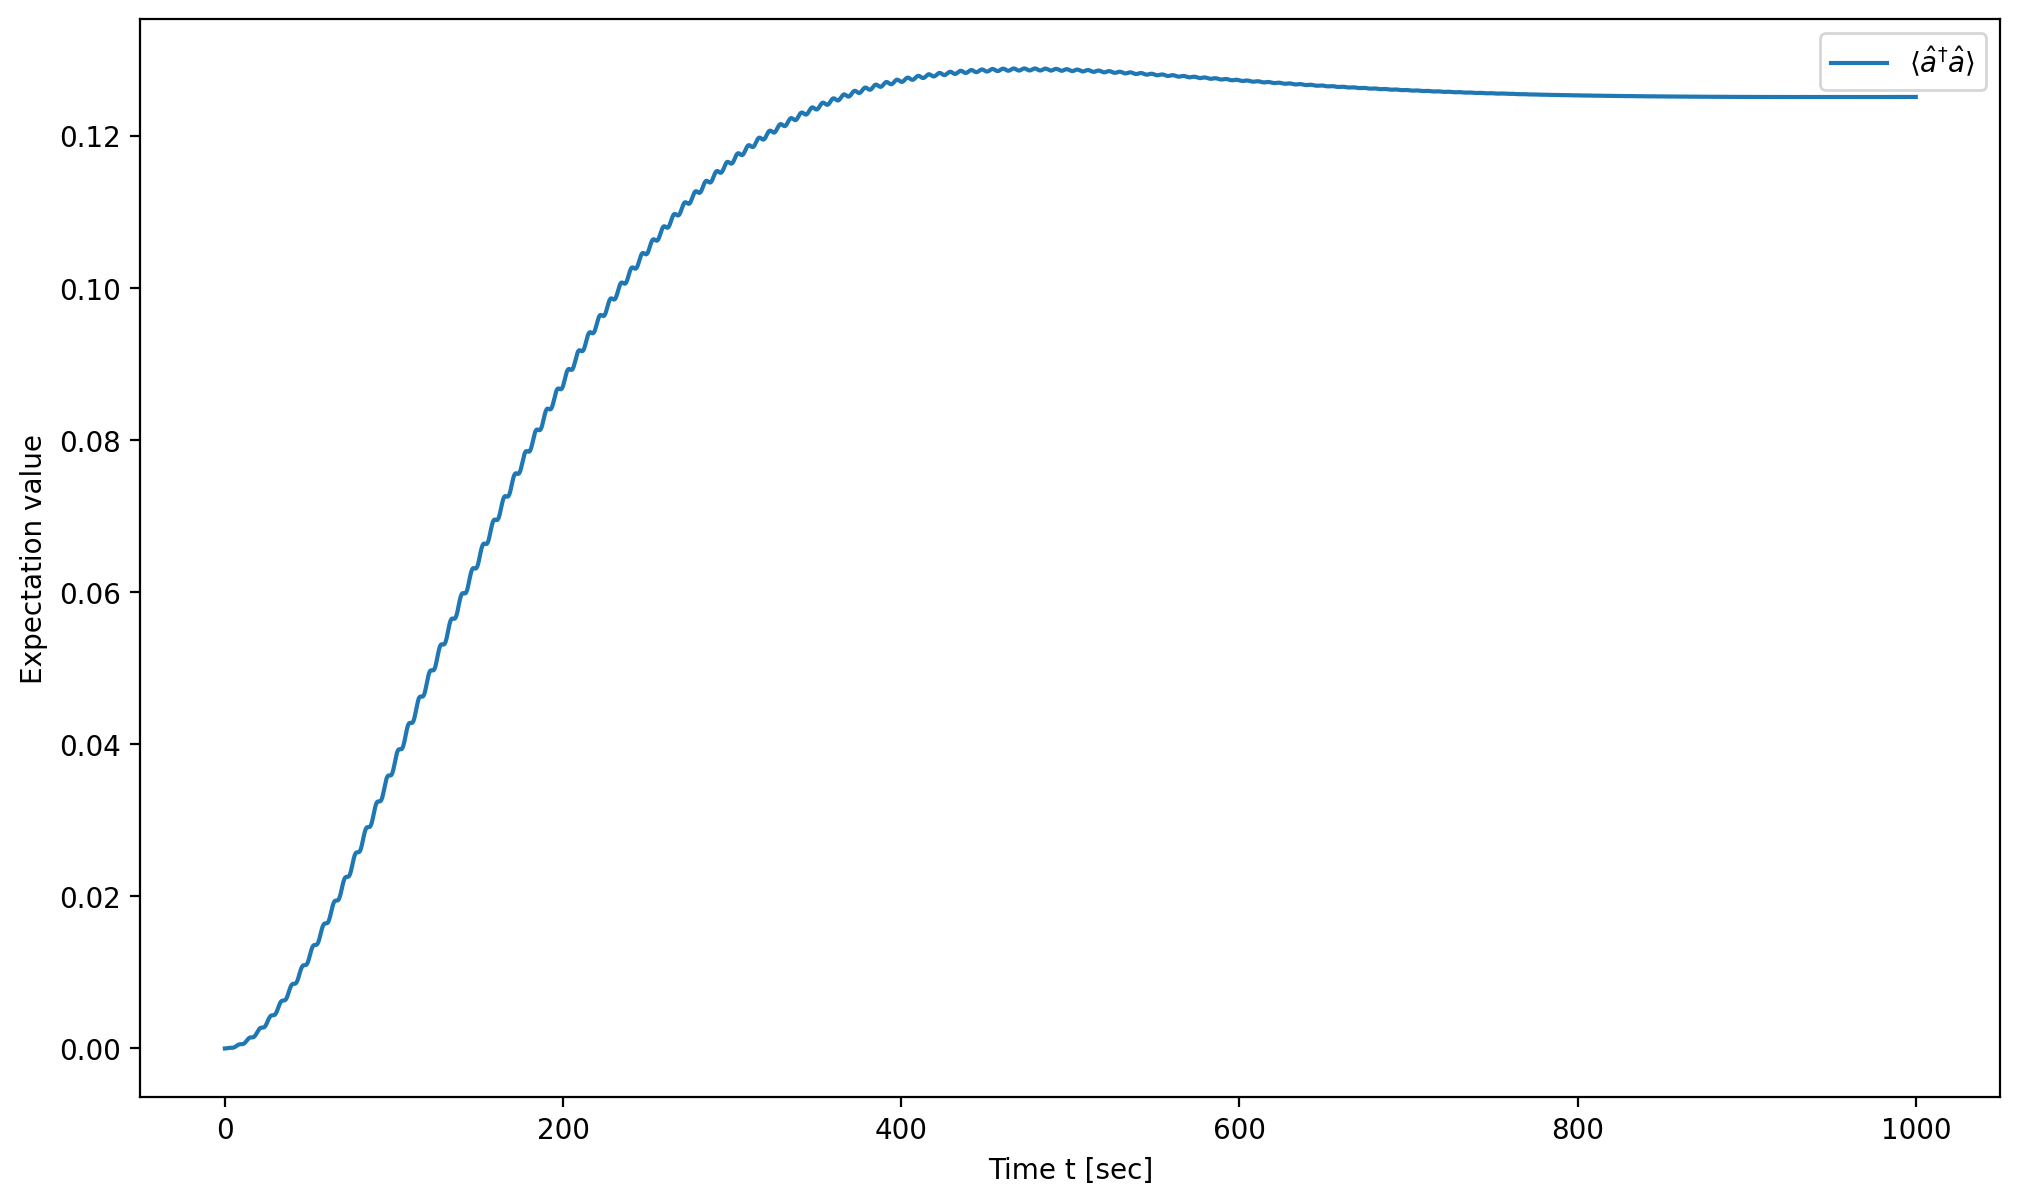

In [16]:
g_til = 0.5
GAMMA = 0.01
KAPPA = 0.01
omega_c = 5 # We assume it is the same as the atom for simplicity (omega_c = omega_a)
omega   = omega_c - g_til
E = 0.005

T0    = 0
Tf    = 1000
Nt    = Tf*50
times = np.linspace(T0, Tf, Nt)
N_ph = 4

psi0 = qtp.tensor(qtp.basis(2,1), qtp.fock(N_ph, 0)) # Initial state
result_g = solve_JC_LME(psi0, omega_c-omega, omega_c-omega, g_til, E, KAPPA, GAMMA, N_ph, T0, Tf, Nt, True)

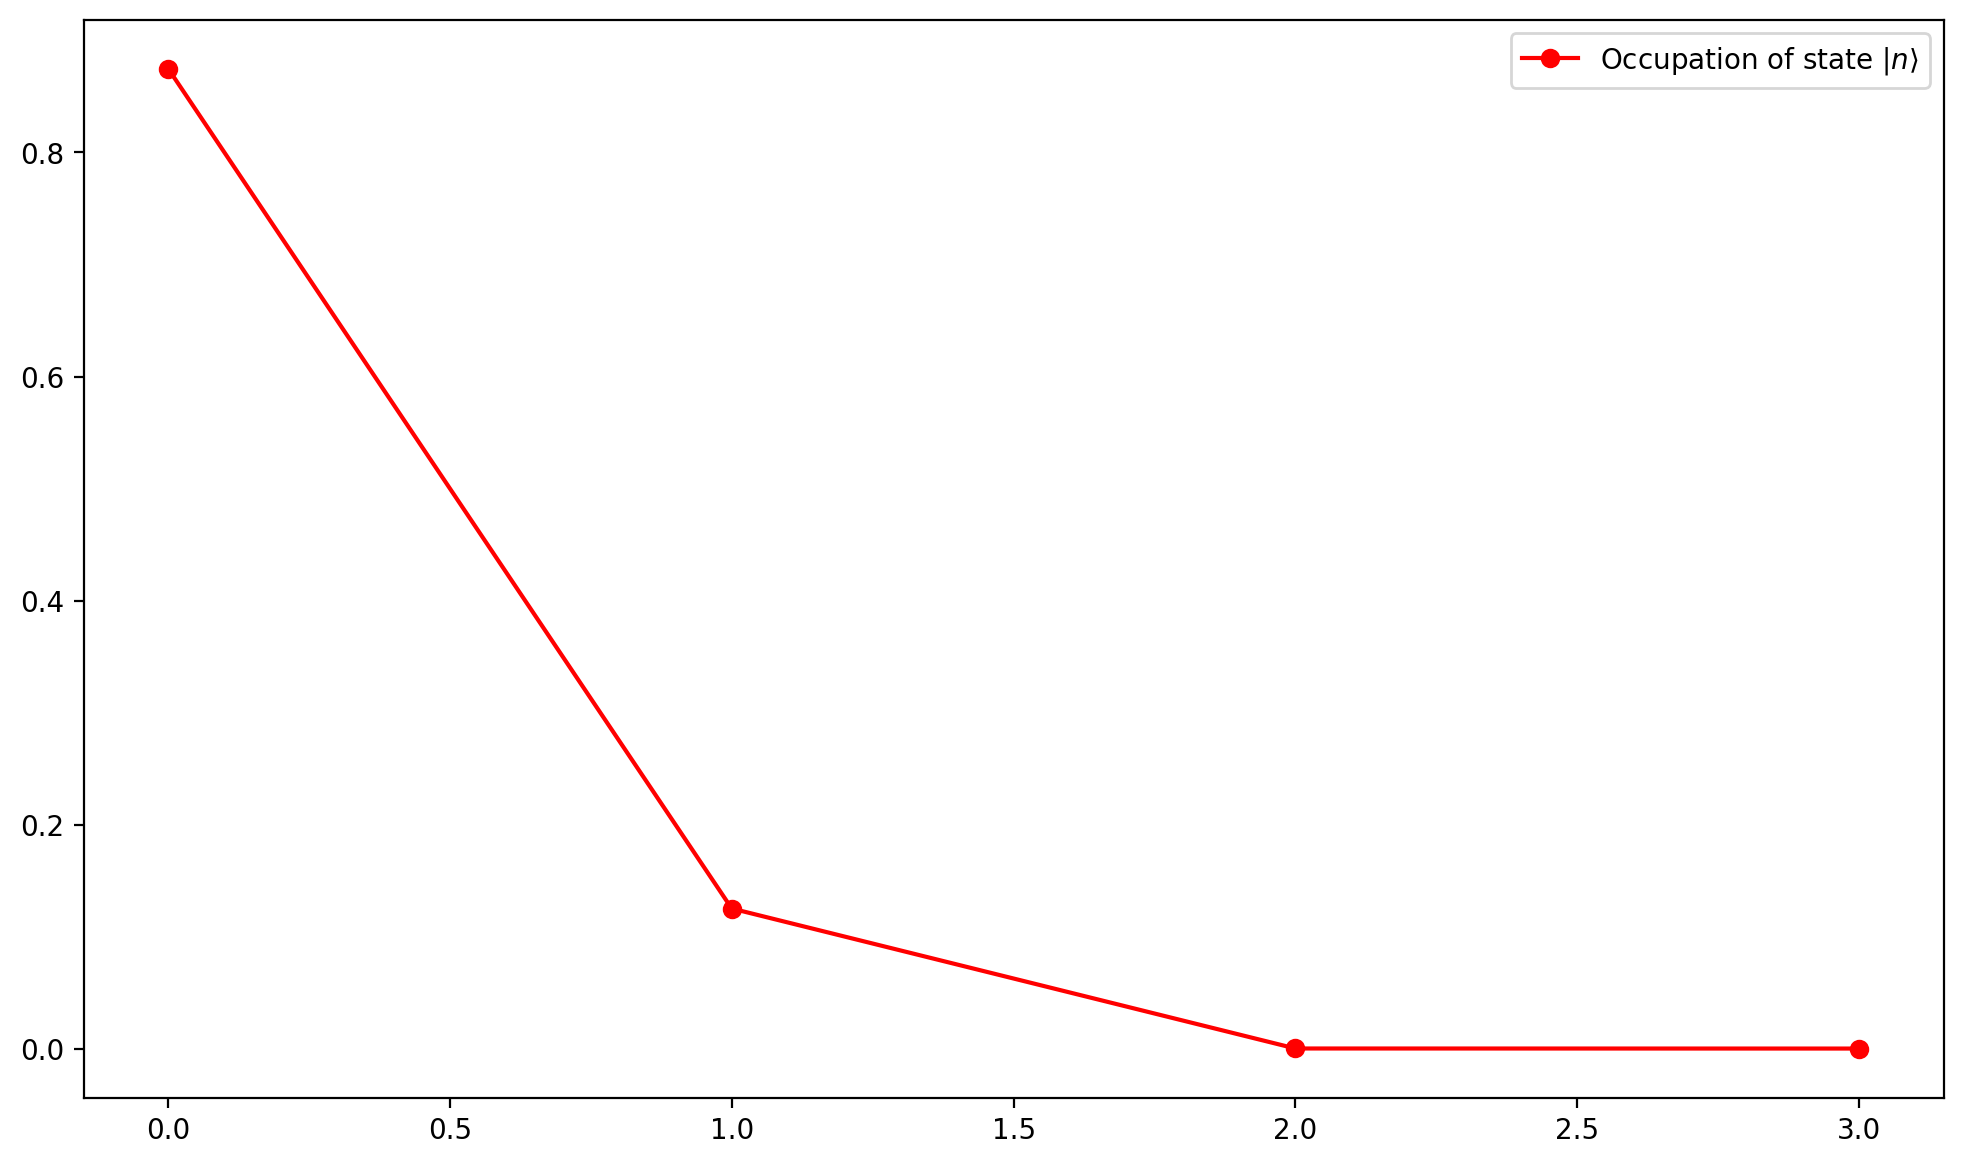

In [17]:
rho_cav_g = result_g.final_state.ptrace(1)
occupations_g = rho_cav_g.diag()
N_list = np.arange(N_ph)

plt.figure(dpi=200, figsize=(12, 7))
plt.plot(N_list, occupations_g, "r-o", label=r"Occupation of state $\vert{n}\rangle$")
plt.legend()
plt.show()

### Changing pumping field amplitude $\mathcal{E}$

In [88]:
E_L = [0.001, 0.005, 0.01, 0.05]
results = solve_JC_LME_parallelized(
    psi0, omega_c-omega, omega_c-omega, [g_til], E_L, [KAPPA], [GAMMA], N_ph, T0, Tf, Nt
)

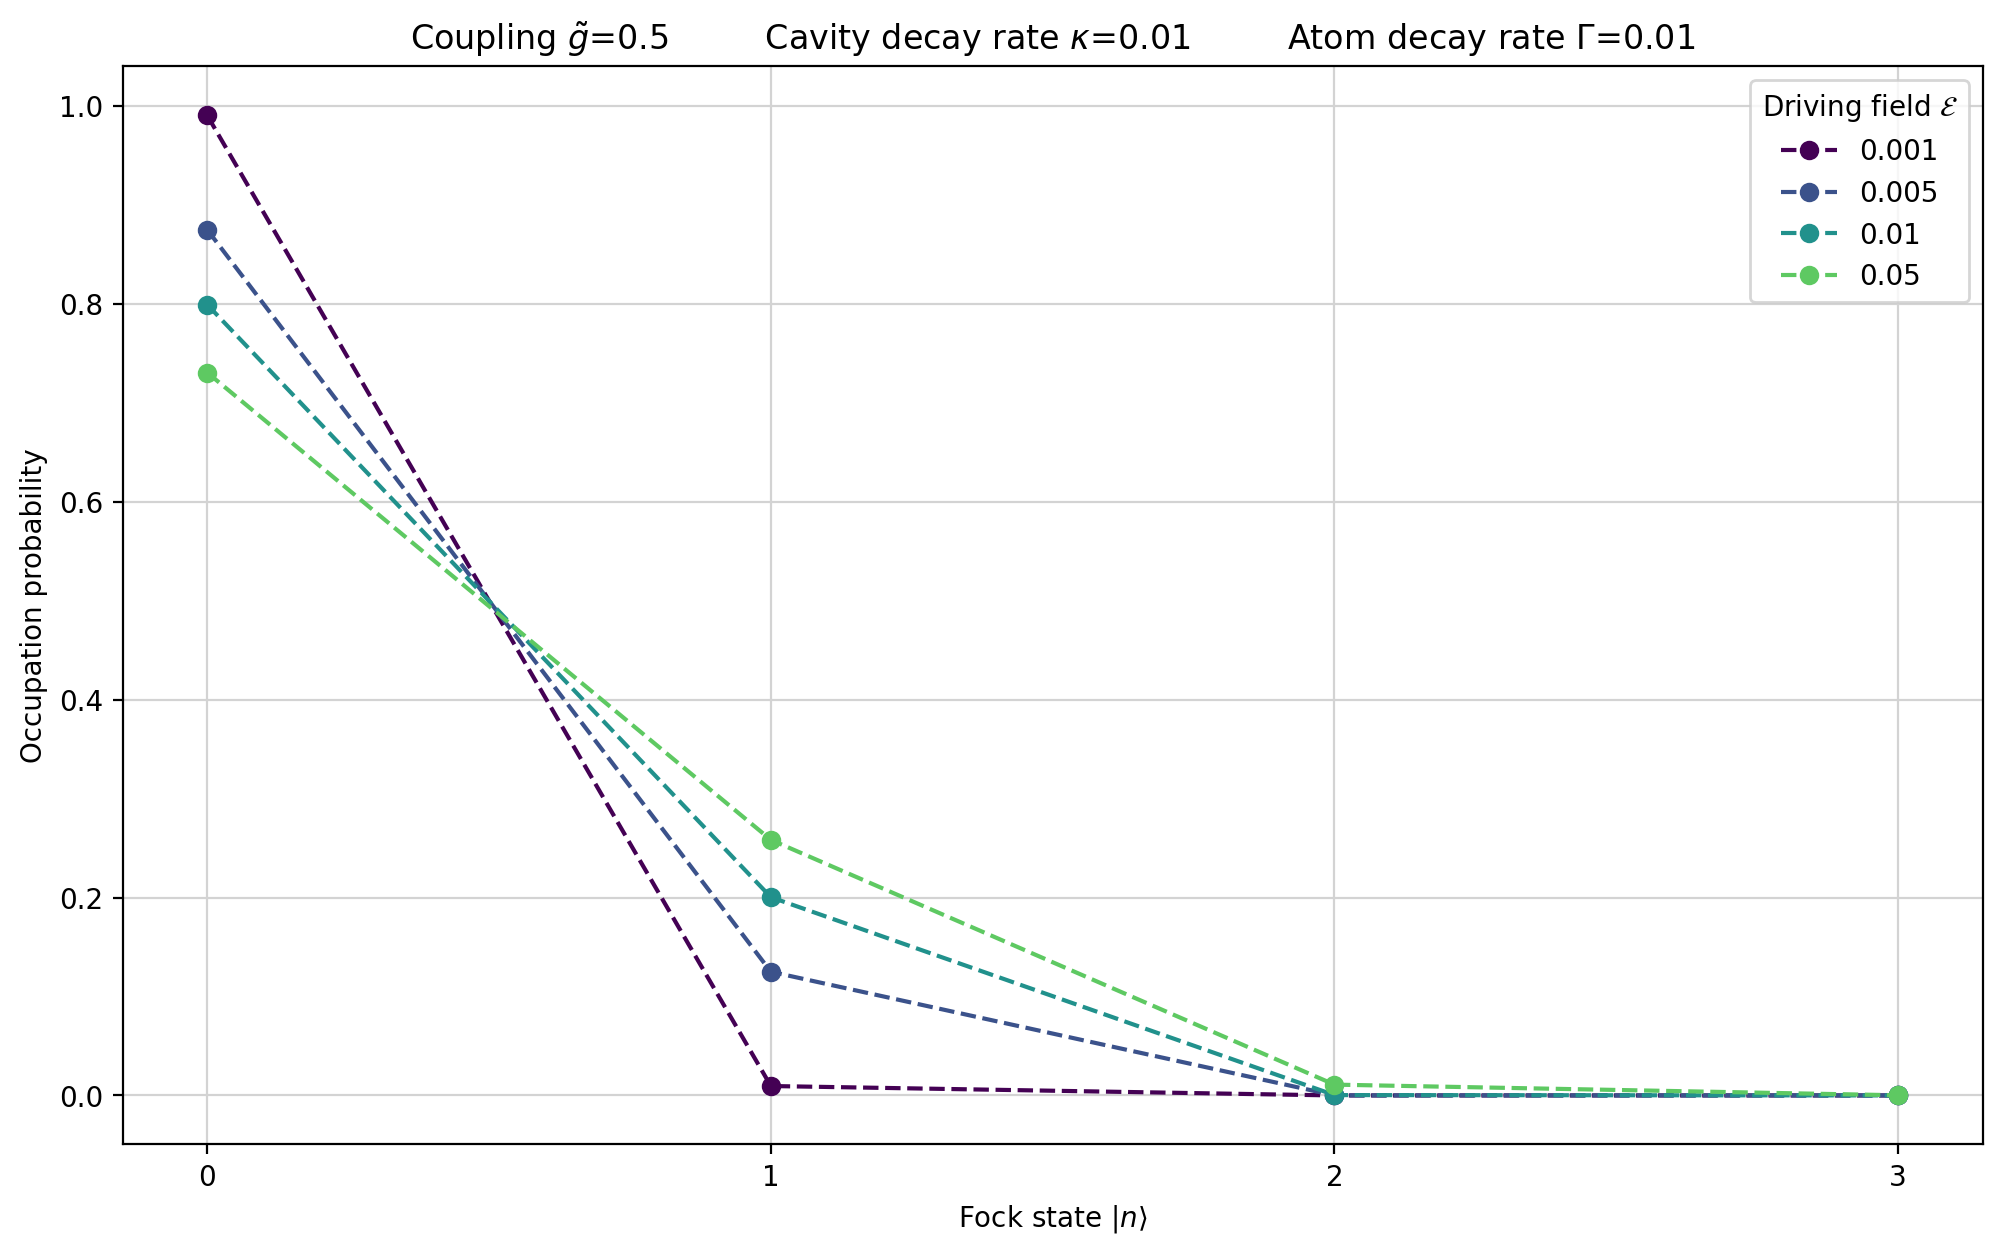

In [89]:
plot_occupations(results, 1)

### Changing coupling $\tilde{g}$

In [117]:
g_til_L = [0.5 + x/1000 for x in range(0, 21)]
# CAREFUL: we are not recomputing omega, so we are moving away from the resonance condition!!!
results = solve_JC_LME_parallelized(
    psi0, omega_c-omega, omega_c-omega, g_til_L, [E], [KAPPA], [GAMMA], N_ph, T0, Tf, Nt
)

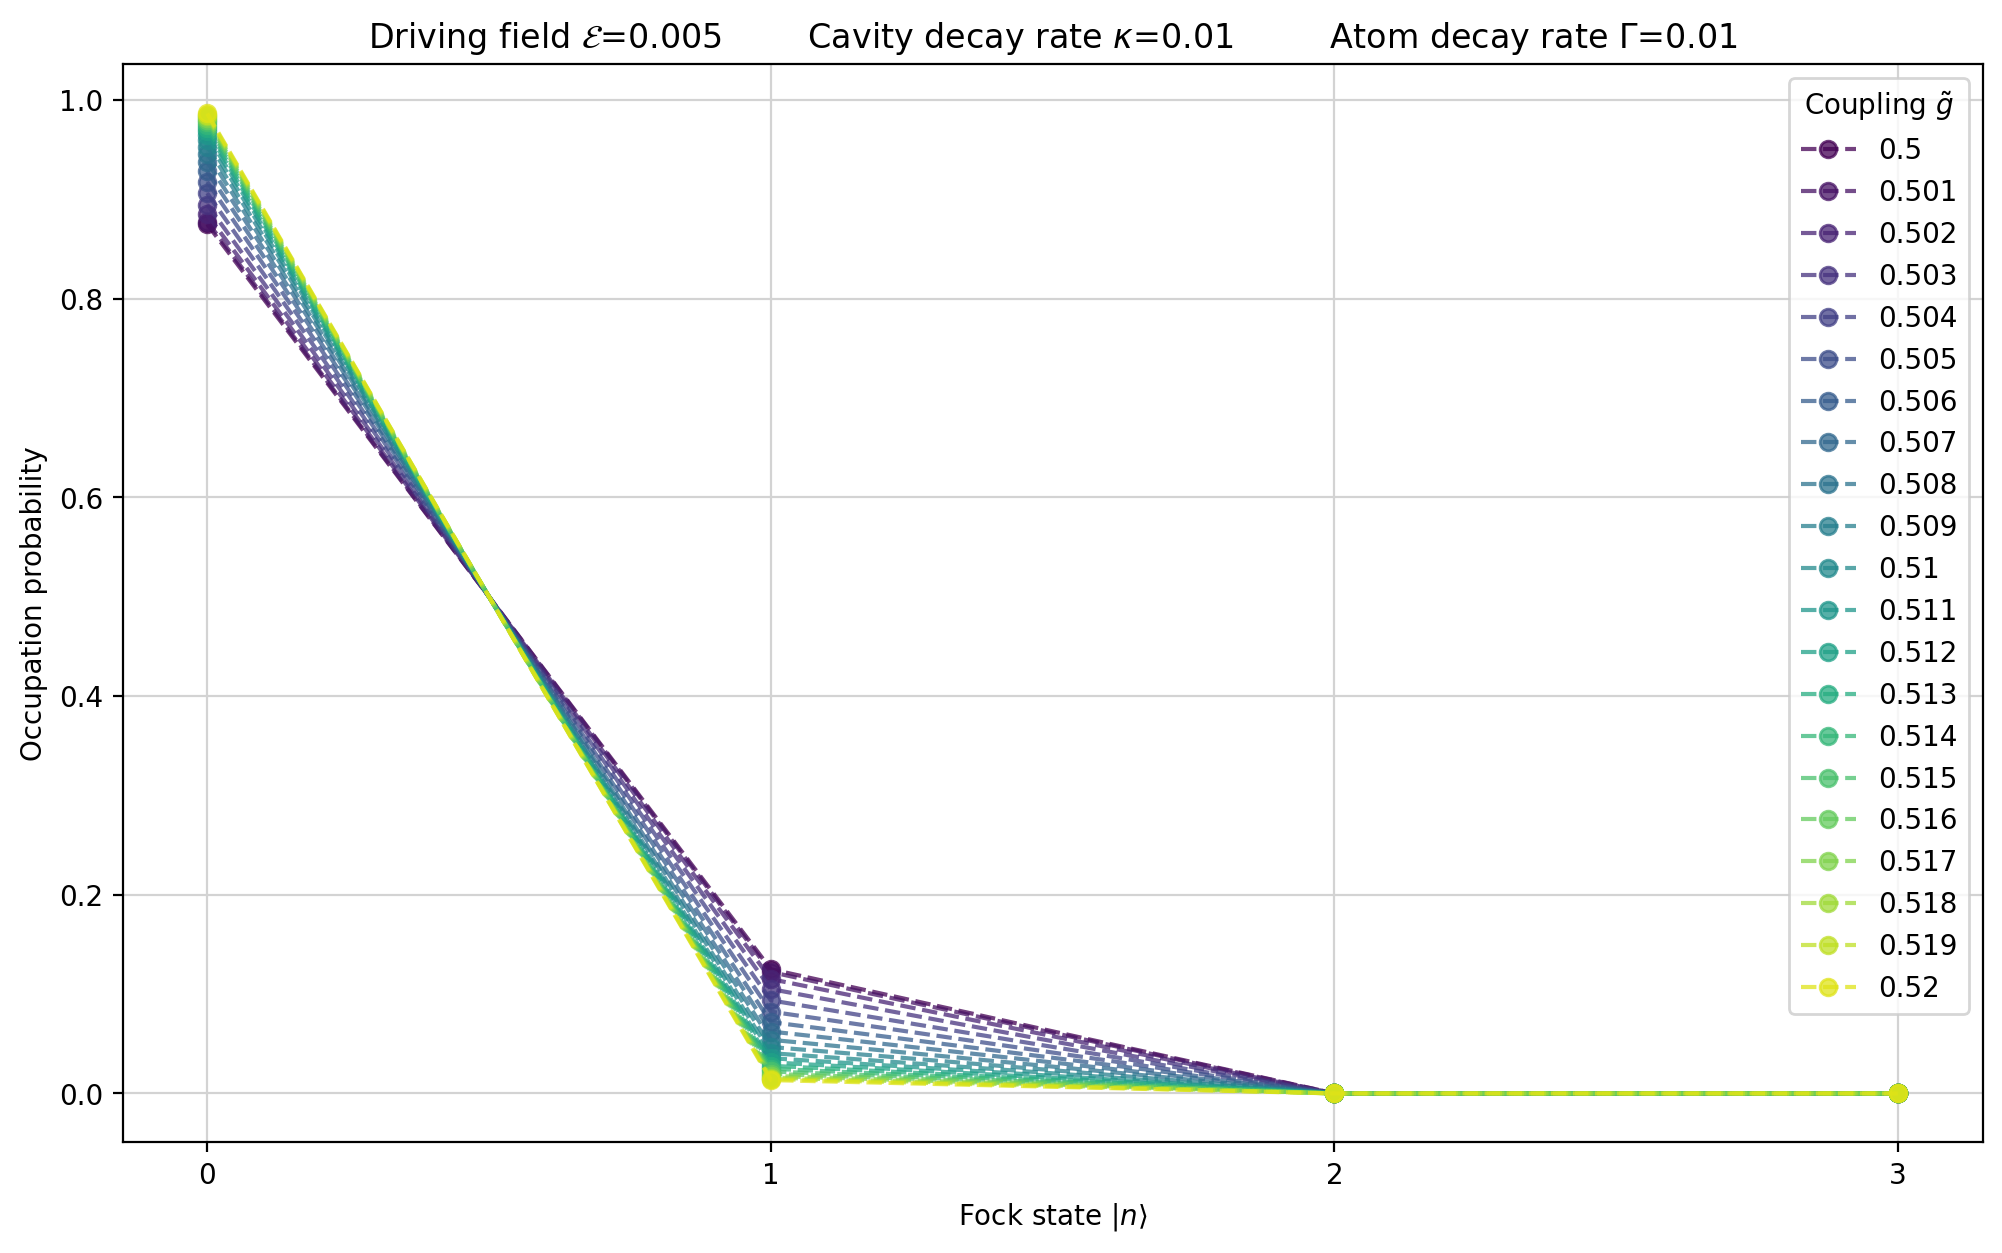

In [118]:
plot_occupations(results, 0)